# Курсовая работа № 2
## Аналитика. Начальный уровень

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

# Заполняем список posts_list необходимой информацией из постов:

In [5]:
vk_token = 'f1e5c46a51871f85ff971476dff08c0b9a926ede6f9150305e47c906e62ac9009e825002d4a11f6c6d00a'

import pandas as pd

# Добавляем библиотеку для отправки запросов:

import requests

# Ссылка с методом для получения информации о посте:

url = 'https://api.vk.com/method/wall.get'

# Количество постов, получаемых за раз:

count = 100

# Позиция поста, с которой получаем очередную сотню постов:

offset = 0

# Список для записи всех постов со страницы:

posts_list = []

# Определим количество постов:

params = {  
    'owner_id': '-66669811',
    'count': 1,
    'v': 5.95,  
    'access_token': vk_token  
}

response = requests.get(url, params = params)

data = response.json()

# Максимальное количество постов:

max_count = data['response']['count']

# Остаток постов, которые ещё не записаны в список:

leftover = max_count

# Цикл для преодоления ограничений API Вконтакте и записи всех постов в список:

while offset < max_count:
    
    params = {  
        'owner_id': '-66669811',
        'count': count,
        'offset': offset,
        'v': 5.95,  
        'access_token': vk_token  
    }

    response = requests.get(url, params = params)

    data = response.json()
    
    # Цикл для записи очередной сотни постов в список:
    
    for i in range(count):
        
        if leftover > i:
        
            x = data['response']['items'][i]
    
            post_dict = {'id': x['id'], 'date': x['date'], 'text': x['text'],
                        'comment_count': x['comments']['count'], 'like_count': x['likes']['count'], 
                        'repost_count': x['reposts']['count'], 'view_count': '', 'vote_count': ''}
        
            # Вводим по той причине, что были времена, когда у постов не было параметра 'views':
        
            try:
            
                post_dict['view_count'] = x['views']['count']
            
            except Exception:
                    
                pass 
            
            # Ищем среди постов те, где были проведены опросы, и добавляем информацию в список постов:
            
            try:
            
                for j in range(len(x['attachments'])):
                
                    if(x['attachments'][j]['type'] == 'poll'):
                    
                        post_dict['vote_count'] = x['attachments'][j]['poll']['votes']
                        
            except Exception:
                    
                pass            
                
            posts_list.append(post_dict)
            
        else:
            
            break
    
    # Производим актуализацию начала следующей выборки:
    
    offset += count
    
    # Производим актуализацию количества ещё недобавленных постов:
    
    leftover -= count
    
# Создаём датафрейм из списка с постами:    
    
df = pd.DataFrame(posts_list)

# Преобразуем столбец с датами в более привычный вид:

In [3]:
from datetime import datetime, timedelta

df['date'] = df['date'].apply(lambda x: (datetime.fromtimestamp(x) - timedelta(hours=0)).strftime('%Y-%m-%d %H:%M:%S'))

# Датафрейм со всеми постами со стены Skillbox:

In [3]:
df

,id,date,text,comment_count,like_count,repost_count,view_count,vote_count
0,204913,2021-09-14 18:38:54,"Нет, это не шутка! Попробовать 34 курса и инте...",49,237,464,36237,
1,209320,2021-09-28 19:00:01,"Сейчас многие хотят в «айти», но не знают, с ч...",0,58,44,6609,
2,209296,2021-09-28 15:40:31,«Что наша жизнь — игра!» — часто слышали эту ф...,14,16,10,7518,
3,209288,2021-09-28 14:59:24,Научитесь создавать сценарии и постройте карье...,6,52,35,12096,
4,209254,2021-09-28 12:21:22,"Удивительно, но даже такие приземленные вещи, ...",16,13,18,7366,
...,...,...,...,...,...,...,...,...
3804,19003,2016-04-03 15:10:10,#internetmarketing #business #skillbox\n\n15 с...,0,4,0,,
3805,18999,2016-04-02 20:04:13,#internetmarketing #business #skillbox\n\nБлес...,0,1,0,,
3806,18998,2016-04-02 15:05:19,#movie #internetmarketing #business #skillbox ...,0,3,0,,
3807,18994,2016-04-01 16:50:13,#studio #business #skillbox \n\n4 вида рекламн...,0,6,0,,


# 1. Проанализируем влияние фактора времени на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Активность будем определять не в абсолютных значениях, а относительно количества просмотров постов. Было бы конечно неплохо иметь данные о количестве подписчиков в каждый рассматриваемый период времени, но пока ограничимся имеющимися данными.

In [4]:
# Ограничим первоначальный датафрейм строками, в которых имеются данные о количестве просомтров постов:

df_with_view = df[df['view_count'] != '']

# Приведём даты к формату datetime:

df_with_view['date'] = pd.to_datetime(df_with_view['date'])

# Приведём тип данных столбцов  'view_count' и 'vote_count' к типу int:

df_with_view['view_count'] = pd.to_numeric(df_with_view['view_count'])

df_with_view['vote_count'] = pd.to_numeric(df_with_view['vote_count'])

<ipython-input-4-53333aa2f78b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_view['date'] = pd.to_datetime(df_with_view['date'])
<ipython-input-4-53333aa2f78b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_view['view_count'] = pd.to_numeric(df_with_view['view_count'])
<ipython-input-4-53333aa2f78b>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

# Датафрейм, содержащий только посты со статистикой просомтров:

In [115]:
df_with_view

,id,date,text,comment_count,like_count,repost_count,view_count,vote_count
0,204913,2021-09-14 18:38:54,"Нет, это не шутка! Попробовать 34 курса и инте...",23,183,371,28553,NaN
1,208457,2021-09-23 14:15:00,Свою первую в жизни профессию мы часто выбирае...,0,12,13,4632,NaN
2,208291,2021-09-23 13:16:40,23 сентября в 15:00 по Москве совместно с [clu...,0,6,3,4930,NaN
3,208255,2021-09-23 12:00:17,Испытывали ли вы когда-нибудь непреодолимое же...,0,5,3,4910,40.0
4,208129,2021-09-22 20:17:24,"Для тех, кто любит цветы и хочет попробовать ч...",0,9,5,8604,NaN
...,...,...,...,...,...,...,...,...
3278,20610,2017-02-09 13:01:49,#дизайнпонедельник - выпуск №7 - Как сделать с...,0,33,2,3670,NaN
3279,20607,2017-02-08 14:21:27,#дизайнпонедельник - выпуск №6 - Профессиональ...,0,22,1,3516,NaN
3280,20550,2017-01-19 21:03:29,,6,20,2,5971,NaN
3281,20547,2017-01-18 20:56:32,,5,7,1,5467,NaN


# 1.1. Выясним, как зависят показатели вовлечённости от месяца в году:

In [116]:
import warnings

warnings.filterwarnings('ignore')

# Скопируем исходный датафрейм:

df_with_view_1_1 = df_with_view.copy()

# Добавим столбцы с информацией о годе и месяце размещения поста:

df_with_view_1_1['year'] = df_with_view_1_1['date'].dt.year

df_with_view_1_1['month'] = df_with_view_1_1['date'].dt.month

# Произведём группировку датафрейма по годам и месяцам, оставим только показатели вовлечённости:

grouped_df_with_view_1_1 = df_with_view_1_1.groupby(['year', 'month'])[['comment_count', 'like_count', 
                                                                'repost_count', 'view_count',
                                                                'vote_count']].mean().reset_index()

# Заменим значения Nan для 'vote_count' на 0:

grouped_df_with_view_1_1['vote_count'] = grouped_df_with_view_1_1['vote_count'].fillna(0)

# Добавим в датафрейм новый столбец с датой замера средних показателей вовлечённости: 

grouped_df_with_view_1_1['control_date'] = pd.to_datetime(grouped_df_with_view_1_1.year.astype(str) 
                                                          + grouped_df_with_view_1_1.month.astype(str), format='%Y%m')

# Средние показатели вовлечённости по годам и месяцам (период с января 2017 по сентябрь 2021):

In [117]:
grouped_df_with_view_1_1

,year,month,comment_count,like_count,repost_count,view_count,vote_count,control_date
0,2017,1,10.000000,18.333333,1.666667,6031.000000,0.000000,2017-01-01
1,2017,2,1.000000,76.111111,3.777778,3382.111111,0.000000,2017-02-01
2,2017,4,0.473684,19.631579,2.736842,3554.210526,0.000000,2017-04-01
3,2017,5,1.636364,67.363636,6.909091,9139.272727,0.000000,2017-05-01
4,2017,6,8.333333,39.666667,4.000000,12425.333333,0.000000,2017-06-01
5,2017,7,4.833333,48.333333,4.666667,22765.500000,606.500000,2017-07-01
6,2017,8,10.222222,42.777778,5.555556,16237.333333,508.000000,2017-08-01
7,2017,9,11.571429,20.285714,0.714286,9189.857143,0.000000,2017-09-01
8,2017,10,4.000000,17.454545,0.909091,9155.909091,488.333333,2017-10-01
9,2017,11,5.055556,41.444444,5.277778,10651.722222,679.250000,2017-11-01


# Построим графики зависимости показателей вовлечённости от месяца и года (период с января 2017 по сентябрь 2021):

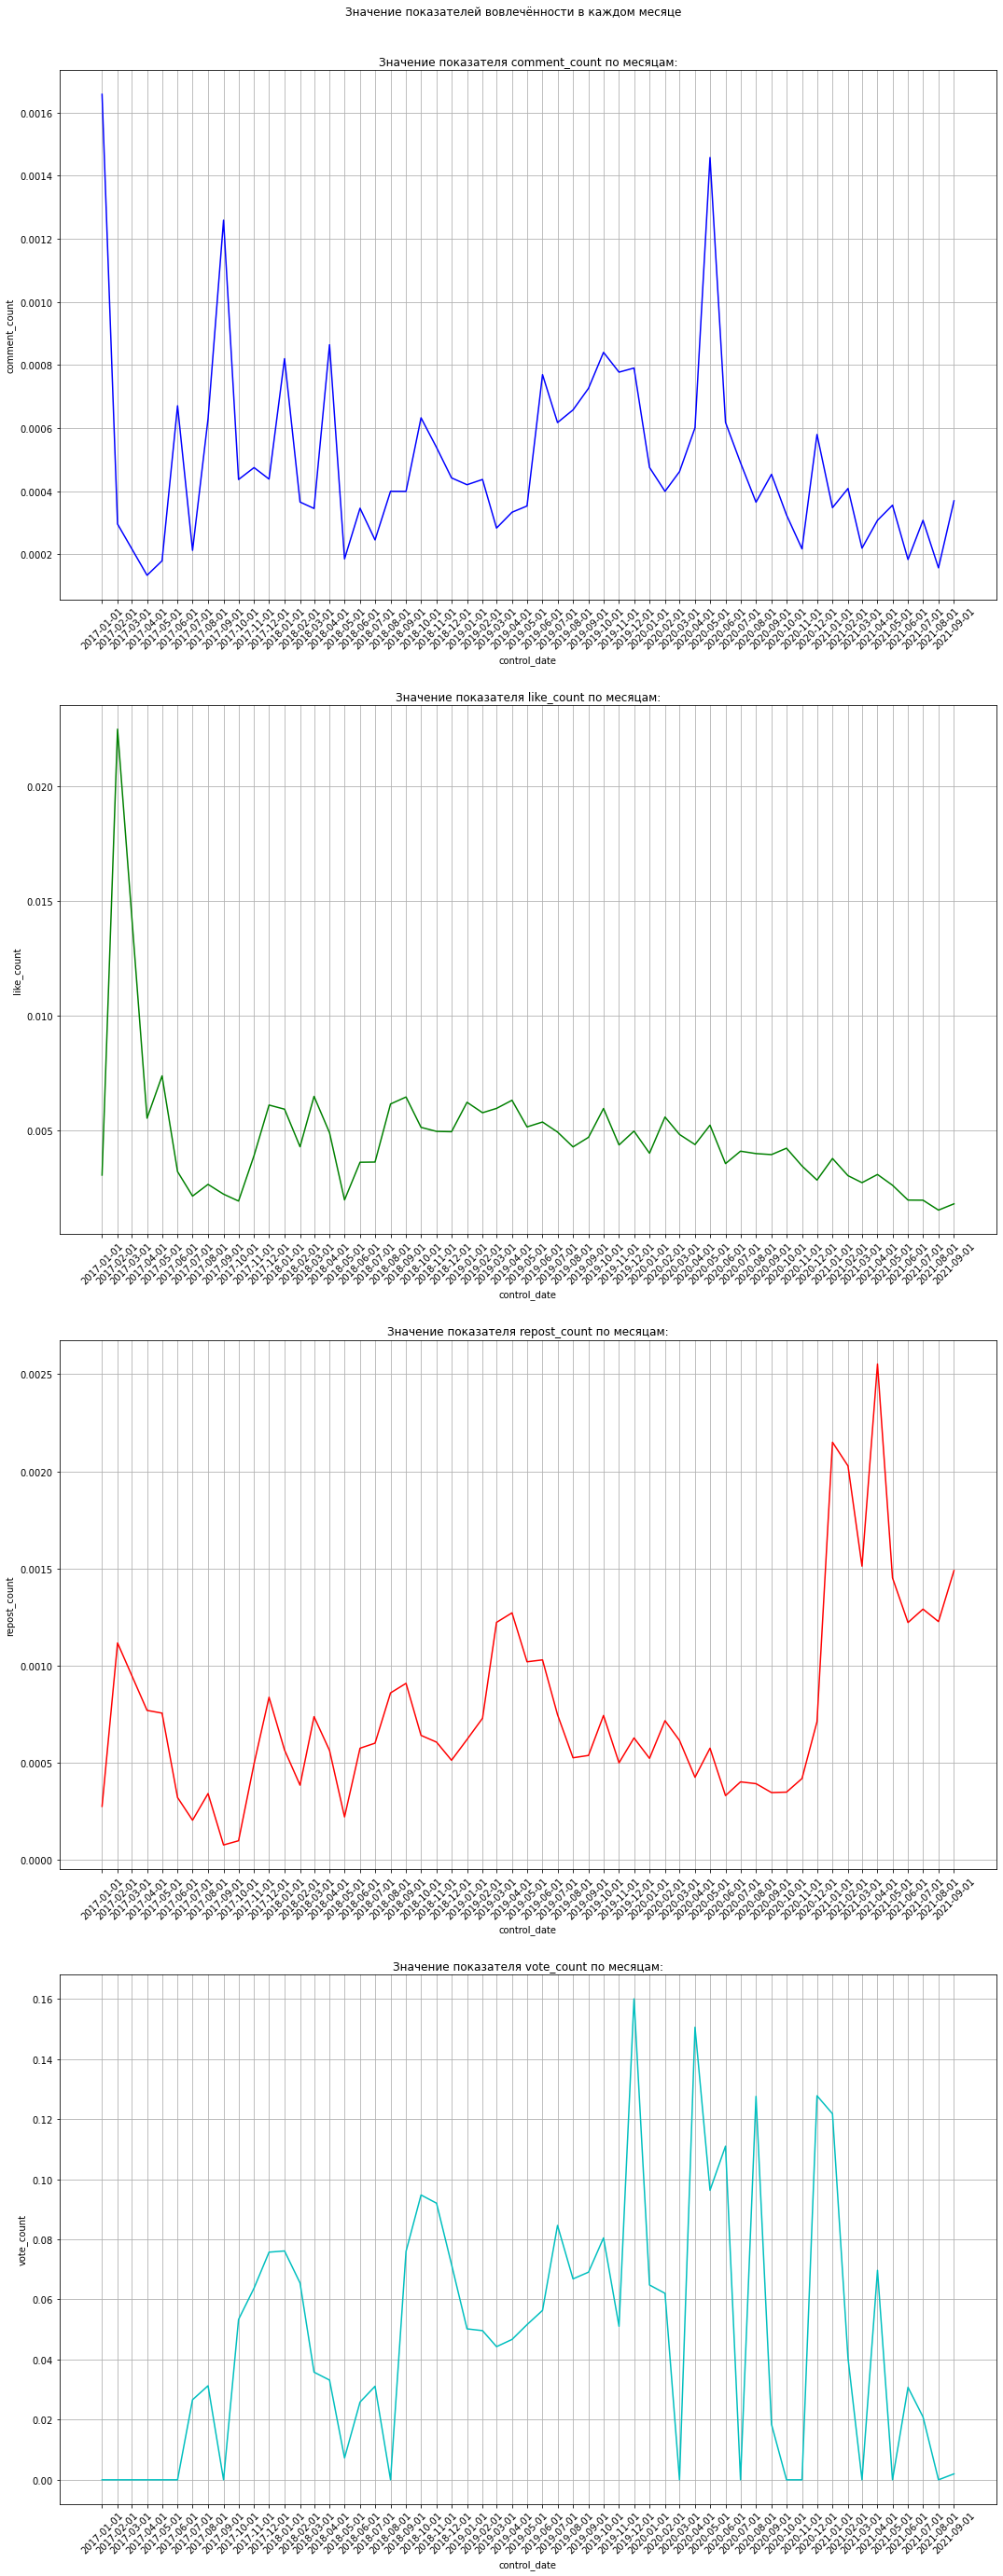

In [118]:
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

# Создадим список закодированных цветов для получения графиков разных цветов:

colors = ['b', 'g', 'r', 'c']

# Cоздадим список контрольных дат для кастомной разбивки оси x по контрольным датам:

control_date_list = []

# Создадим первую контрольную дату и добавим её в список:

first_date = pd.to_datetime('2017' + '01' + '01', format='%Y%m%d').date()

control_date_list.append(first_date)

# Создадим цикл для добавления в список первого числа каждого месяца каждого года из диапазона 
# каждый месяц в диапазоне от января 2017 до сентября 2021 включительно:

for i in range(1,57):
    
    control_date_list.append((control_date_list[i-1] + relativedelta(months=+1)))
    
# Создадим фигуру с 4 пустыми полями для графиков:

fig, axs = plt.subplots(figsize=(18, 48), nrows=4)

inclusion_indicator_list = ['comment_count', 'like_count', 'repost_count', 'vote_count']

# Заполним фигуры значениями из датафрейма:

for i in range(len(inclusion_indicator_list)):
    
    # Создадим вспомогательный датафрейм для конкретного показателя:
    
    data = grouped_df_with_view_1_1[['control_date', inclusion_indicator_list[i], 'view_count']]
    
    data['rilative_indicator'] = data[inclusion_indicator_list[i]]/data['view_count']
    
    # Создадим ссылку на элемент из списка axs:
    
    ax = axs[i]
    
    # Построим график, задав стобцы вспомогательного датафрейма в качестве значений для осей x и y и указав цвет графика:
    
    ax.plot(data['control_date'], data['rilative_indicator'], color=colors[i])
    
    # Установим наименование оси y:
    
    ax.set_ylabel(inclusion_indicator_list[i])
    
    # Установим наименование оси x:
    
    ax.set_xlabel('control_date')
    
    # Установим наименование заголовка графика:

    ax.set_title('Значение показателя ' + inclusion_indicator_list[i] + ' по месяцам:') 
    
    # Задаим поворот значений на 45 градусов для оси x:
    
    ax.tick_params(axis='x', labelrotation=45)
    
    # Сделаем разбивку оси x по контрольным датам из списка 'control_date_list':

    ax.set_xticks(control_date_list)

    ax.set_xticklabels(control_date_list)
    
    # Добавим сетку:
    
    ax.grid()
    
# Установим наименование заголовка фигуры:
    
fig.suptitle("Значение показателей вовлечённости в каждом месяце", y=0.9)  

# Зададим отступы между графиками:

plt.subplots_adjust(wspace = 0, hspace = 0.2)
  
# Покажем графики:

plt.show()

# Выводы:
1. Наиболее значимые пики по количеству комментариев приходятся на январь 2017 года (первый месяц существования группы в Вконтакте), сентябрь 2017 года и май 2020 года.
2. Заметный пик по количеству лайков приходится на февраль 2017 года. В остальные периоды всё выглядит более ровно, но среднее количество лайков постоянно сокращается.
3. Значимые пики по количеству репостов приходятся на февраль 2017 года, апрель 2019 года. С ноября 2020 года происходит заметное увеличение количества репостов с пиками в январе 2021 года и апреле 2021 года, в среднем с ноября 2020 года количество репостов увеличилось до 3 раз по отношению к предшествующему периоду.
4. Нулевые значения количества голосов в опросах соответствуют месяцам, когда опросов вообще не было. Если не считать эти месяцы, видим, что первый раз среднее количество голосующих значительно выросло в сентябре 2018 года, затем в декабре 2019 года. С февраля 2021 года видим снижение количества голосующих.

# 1.2. Выясним, как зависят показатели вовлечённости от времени в течение дня:

In [119]:
import warnings

warnings.filterwarnings('ignore')

# Скопируем исходный датафрейм:

df_with_view_1_2 = df_with_view.copy()

# Добавим столбцы с информацией о часе размещения поста:

df_with_view_1_2['hour'] = df_with_view_1_2['date'].dt.hour

df_with_view_1_2

# Произведём группировку датафрейма по часам, оставим только показатели вовлечённости:

grouped_df_with_view_1_2 = df_with_view_1_2.groupby('hour')[['comment_count', 'like_count', 
                                                                'repost_count', 'view_count',
                                                                'vote_count']].mean().reset_index()

# Заменим значения Nan для 'vote_count' на 0:

grouped_df_with_view_1_2['vote_count'] = grouped_df_with_view_1_2['vote_count'].fillna(0)

# Средние показатели вовлечённости по часам:

In [120]:
grouped_df_with_view_1_2

,hour,comment_count,like_count,repost_count,view_count,vote_count
0,0,0.000000,15.000000,2.000000,6718.000000,0.000000
1,9,5.000000,73.000000,10.000000,18172.000000,0.000000
2,10,7.545455,43.272727,6.636364,11979.818182,0.000000
3,11,11.827068,62.729323,13.977444,16802.255639,0.000000
4,12,12.403670,83.807339,19.830275,18759.711009,1057.454545
5,13,10.527778,87.454861,20.031250,19375.555556,956.333333
6,14,8.801653,79.384298,13.702479,18038.747934,1545.800000
7,15,8.876471,71.382353,14.747059,18986.517647,1532.363636
8,16,3.817669,59.757519,10.885338,14008.652256,557.545455
9,17,13.250000,72.440789,15.986842,28766.486842,1049.000000


# Построим графики зависимости показателей вовлечённости от часа суток (один график для каждого показателя):

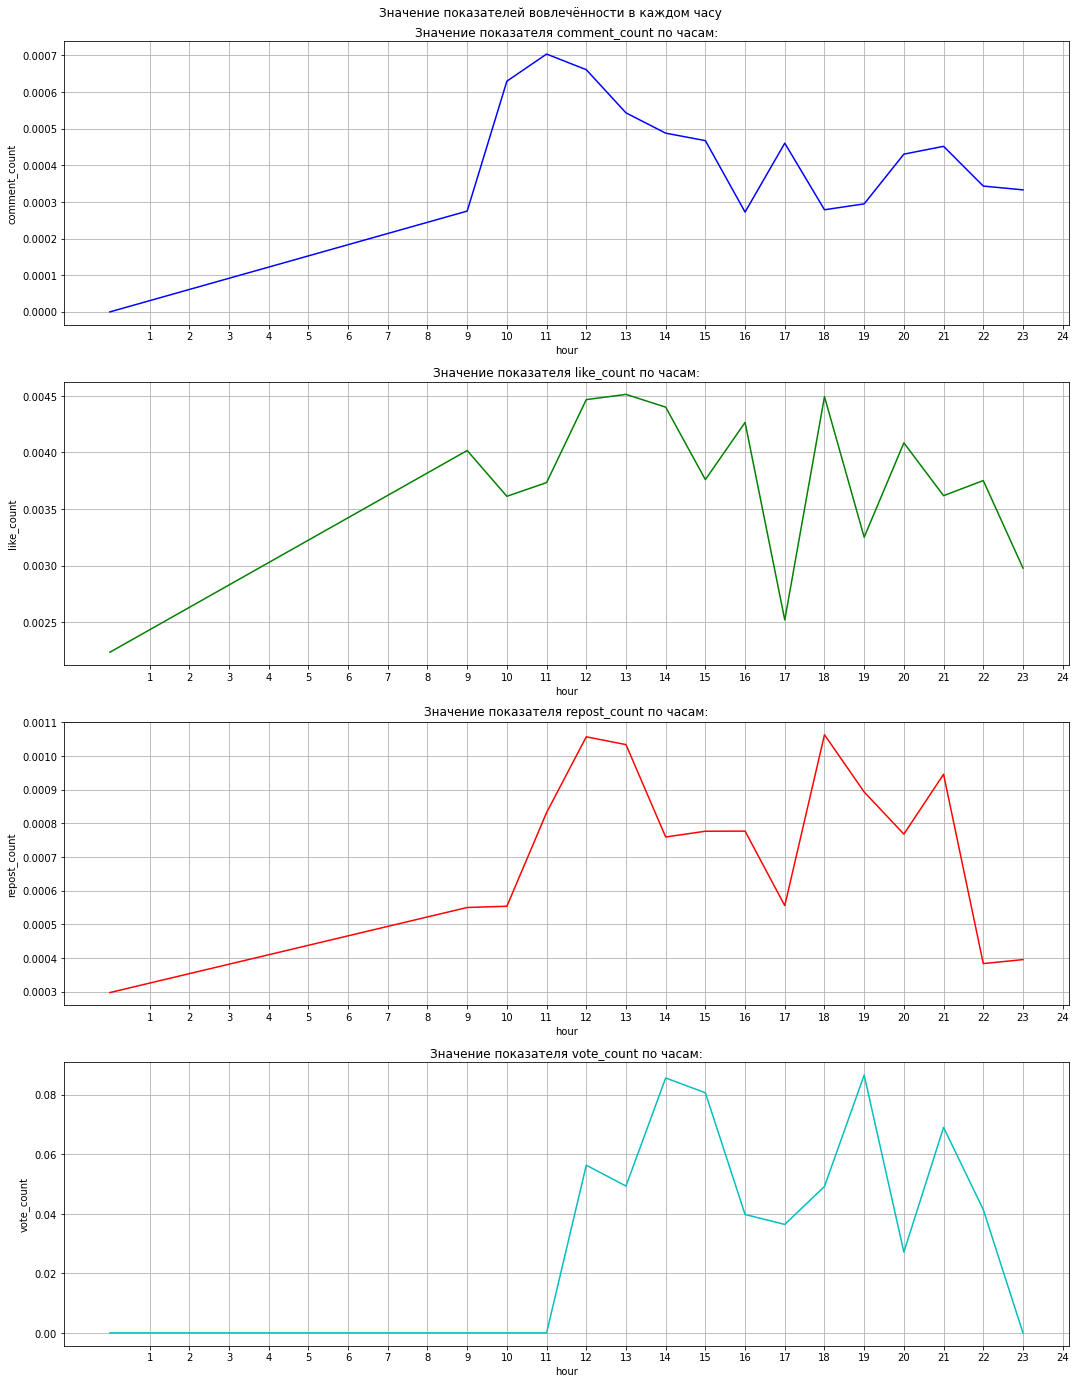

In [121]:
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

# Создадим список закодированных цветов для получения графиков разных цветов:

colors = ['b', 'g', 'r', 'c']

# Создадим список с часами:

hour_list = range(1,25)
    
# Создадим фигуру с 4 пустыми полями для графиков:

fig, axs = plt.subplots(figsize=(18, 24), nrows=4)

inclusion_indicator_list = ['comment_count', 'like_count', 'repost_count', 'vote_count']

# Заполним фигуры значениями из датафрейма:

for i in range(len(inclusion_indicator_list)):
    
    # Создадим вспомогательный датафрейм для конкретного 'course_name':
    
    data = grouped_df_with_view_1_2[['hour', inclusion_indicator_list[i], 'view_count']]
    
    data['rilative_indicator'] = data[inclusion_indicator_list[i]]/data['view_count']
    
    # Создадим ссылку на элемент из списка axs:
    
    ax = axs[i]
    
    # Построим график, задав стобцы вспомогательного датафрейма в качестве значений для осей x и y и указав цвет графика:
    
    ax.plot(data['hour'], data['rilative_indicator'], color=colors[i])
    
    # Установим наименование оси y:
    
    ax.set_ylabel(inclusion_indicator_list[i])
    
    # Установим наименование оси x:
    
    ax.set_xlabel('hour')
    
    # Установим наименование заголовка графика:

    ax.set_title('Значение показателя ' + inclusion_indicator_list[i] + ' по часам:') 

    # Зададим разбивку оси x по часам:

    ax.set_xticks(hour_list)

    ax.set_xticklabels(hour_list)    
    
    # Добавим сетку:
    
    ax.grid()
    
# Установим наименование заголовка фигуры:
    
fig.suptitle("Значение показателей вовлечённости в каждом часу", y=0.9)  

# Зададим отступы между графиками:

plt.subplots_adjust(wspace = 0, hspace = 0.2)
  
# Покажем графики:

plt.show()

# Выводы:
Пики средних показателей вовлечённости по часам примерное совпадают друг с другом и приходятся на 12, 18-19 и 21 час дня.

# 2. Произведём аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике.

In [5]:
import re

# Скопируем исходный датафрейм:

df_with_view_2 = df_with_view.copy()

# Выражение для поиска тега в посте:

pattern = r'[#]\w+'

# Добавим столбец с тегами:

df_with_view_2['tags'] = df_with_view_2['text'].apply(lambda x : re.findall(pattern, x))

# Заменим Nan-ы в столбце tags на '#somecategory':

df_with_view_2['tags'].fillna('#somecategory', inplace=True)

# Есть строки, у которых в столбце tags содержатся списки из нескольких тегов. Разобъём эти строки на несколько:

df_with_view_2_2 = df_with_view_2.explode('tags')

# Сгруппируем посты по тегам и определим количество постов для каждого тега:

grouped_df_with_view_2 = df_with_view_2_2.groupby('tags')['id'].count().reset_index()

# Переименуем столбец 'id', чтобы заголовок отражал суть содержимого столбца:

grouped_df_with_view_2.rename(columns = {'id':'count_of_posts'}, inplace = True)

# Датафрейм, содержащий информацию о тегах и количестве постов с такими тегами:

In [178]:
grouped_df_with_view_2

,tags,count_of_posts
0,#0oj0Vs,1
1,#10,1
2,#191970,1
3,#2,1
4,#3D_графика_Skillbox,1
5,#3RDJou,2
6,#5yYXvP,1
7,#6,1
8,#6666981124311,1
9,#6hfP5N,20


## Видим, что в столбце с тегами есть невнятные значения вроде чисел или наборов букв и цифр. Кроме того есть теги очень похожие друг на друга, которые явно нуждаются в обобщении. Далее проведём обобщение и определим категорию каждого поста:

In [6]:
# Создадим список рубрик (категорий): 

category_list = ['дизайн', 'маркетинг', 'программирование', 'курс', 'вдохновляет', 
                 'игра', 'совет', 'трудоустройство', 'управление', 'calendar',
                'drevolution', 'friday_typeface', 'history', 'read', 'reviews',
                'анонс', 'team', ' айдентик', 'закладки', 'вебинар', 'кейс',
                'конкурс', 'лекторий', 'марафон', 'новости', 'расписание',
                'работа студента', 'статья', 'образование', 'answer', 'баттл', 
                 'offf', 'игра по управлению', 'collection', 'моушн', 
                 'психология', 'мультимедиа', 'лояльность', 'business_school', 
                 'день']

# Создадим список рубрик (категорий) для поиска по тексту:

category_list_2 = ['дизайн', 'маркетинг', 'программирование', 'игра',
                 'трудоустройство', 'управление','совет', 'фриланс',
                'drevolution', 'friday_typeface', 'history', 'английский',
                'анонс', 'team', ' айдентик', 'закладки', 'вебинар',
                'конкурс', 'лекторий', 'марафон', 'расписание',
                'баттл', 'кейс', 'offf', 'моушн', 'business_school',
                 'психология', 'мультимедиа', 'лояльность', 'youtube']

# Составим словарь, в котором ключами будут являться слова, которые ассоциируются с категориями из списка категорий, 
# а значениями - сами категории:

category_dict = {'мркетинг': 'маркетинг',
                 'marketing': 'маркетинг',
                 'code': 'программирование',
                 'design': 'дизайн',
                 'management': 'управление',
                 'weekbook': 'read',
                 'иллюстрация': 'дизайн',
                 'вакансии': 'трудоустройство',
                 'карьер': 'трудоустройство',
                 'полезное': 'совет',
                 'cтудент': 'работа студента',
                 'шрифт': 'дизайн',
                 'бакалавриат': 'образование',
                 'РАНХиГС': 'образование',
                 'моушен': 'моушн',
                 'battle': 'баттл',
                 'графика': 'дизайн',
                 'анимация': 'дизайн',
                 'MBA': 'образование',
                 'гейм': 'игра',
                 'игры': 'игра',
                 'фотошоп': 'дизайн',
                 'photoshop': 'дизайн',
                 'кант': 'образование',
                 'английск': 'английский',
                 'по_управлению': 'игра по управлению',
                 'поуправлению': 'игра по управлению',
                 'работы_студентов': 'работа студента',
                 'работа_cтудента': 'работа студента'}

# Создадим список списков для добавления категорий:

category_list_for_df = []

# Заполним список пустыми списками для дальнейшего добавления категорий:

for i in range(len(df_with_view_2)):
    
    category_list_for_df.append([])
    
# Определим категорию для каждой строки датафрейма 'df_with_view_2':

for i in range(len(df_with_view_2)):
    
    # Заполним ячейку списка 'category_list_for_df' значениями из списка 'category_list', 
    # которые содержатся в соответствующей ячейке df_with_view_2['tags']:
        
    for j in range(len(category_list)):
        
        if category_list[j] in str(df_with_view_2['tags'][i]).lower():
            
            category_list_for_df[i].append(category_list[j])
      
    # Если мы ещё не заполнили ячейку списка 'category_list_for_df', добавим в неё значения, соответствующие ключам из
    # словаря 'category_dict', которые содержатся в соответствующей ячейке df_with_view_2['tags']:    
    
    if category_list_for_df[i] == []:
        
        for k in range(len(category_dict.keys())):
            
            if list(category_dict.keys())[k] in str(df_with_view_2['tags'][i]).lower():
                
                category_list_for_df[i].append(category_dict[list(category_dict.keys())[k]])
                
    # Если мы всё ещё не заполнили ячейку списка 'category_list_for_df', добавим в неё значения из списка 'category_list', 
    # которые содержатся в соответствующей ячейке df_with_view_2['text']:
    
    if category_list_for_df[i] == []:
        
        for p in range(len(category_list_2)):
            
            if category_list_for_df[i] == []:
        
                if category_list_2[p] in str(df_with_view_2['text'][i]).lower():
            
                    category_list_for_df[i].append(category_list_2[p])
                
    # Если мы ещё не заполнили ячейку списка 'category_list_for_df', добавим в неё значения, соответствующие ключам из
    # словаря 'category_dict', которые содержатся в соответствующей ячейке df_with_view_2['text']:    
    
    if category_list_for_df[i] == []:
        
        for t in range(len(category_dict.keys())):
            
            if category_list_for_df[i] == []:
            
                if list(category_dict.keys())[t] in str(df_with_view_2['text'][i]).lower():
                
                    category_list_for_df[i].append(category_dict[list(category_dict.keys())[t]])               
                
    # Если ячейка всё ещё пустая, заполним её значением 'other':
    
    if category_list_for_df[i] == []:
    
        category_list_for_df[i].append('other')
            
# Добавим в датафрейм 'df_with_view_2' столбец с категориями:

df_with_view_2['category'] = pd.Series(category_list_for_df)

# Есть строки, у которых в столбце 'category' содержатся списки из нескольких категорий. Разобъём эти строки на несколько:

df_with_view_2_3 = df_with_view_2.explode('category')

# Для подсчёта количества столбцов по категориям добавим столбец:

df_with_view_2_3['count_of_posts'] = 1

# Датафрейм, содержащий информацию о категориях для каждого поста:

In [199]:
df_with_view_2_3

,id,date,text,comment_count,like_count,repost_count,view_count,vote_count,tags,category,count_of_posts
0,204913,2021-09-14 18:38:54,"Нет, это не шутка! Попробовать 34 курса и инте...",50,239,467,36450,NaN,[],other,1
1,209457,2021-09-29 11:21:06,Вам когда-нибудь приходила в голову мысль: «Во...,2,9,5,4550,NaN,[],other,1
2,209320,2021-09-28 19:00:01,"Сейчас многие хотят в «айти», но не знают, с ч...",0,64,50,7681,NaN,[],other,1
3,209296,2021-09-28 15:40:31,«Что наша жизнь — игра!» — часто слышали эту ф...,15,18,11,8151,NaN,[],игра,1
4,209288,2021-09-28 14:59:24,Научитесь создавать сценарии и постройте карье...,6,55,37,12902,NaN,[],трудоустройство,1
...,...,...,...,...,...,...,...,...,...,...,...
3290,20610,2017-02-09 13:01:49,#дизайнпонедельник - выпуск №7 - Как сделать с...,0,33,2,3670,NaN,[#дизайнпонедельник],дизайн,1
3291,20607,2017-02-08 14:21:27,#дизайнпонедельник - выпуск №6 - Профессиональ...,0,22,1,3516,NaN,[#дизайнпонедельник],дизайн,1
3292,20550,2017-01-19 21:03:29,,6,20,2,5971,NaN,[],other,1
3293,20547,2017-01-18 20:56:32,,5,7,1,5467,NaN,[],other,1


# Наконец займёмся аналитикой показателей вовлечённости:

In [7]:
# Произведём группировку датафрейма по категориям, оставим только показатели вовлечённости:

grouped_df_with_view_2_3 = df_with_view_2_3.groupby('category').agg({'comment_count' : 'mean',
                                                                     'like_count' : 'mean',
                                                                     'repost_count' : 'mean',
                                                                     'view_count' : 'mean',
                                                                     'vote_count' : 'mean',
                                                                     'count_of_posts' : 'sum'}).reset_index()

# Заменим значения Nan для 'vote_count' на 0:

grouped_df_with_view_2_3['vote_count'] = grouped_df_with_view_2_3['vote_count'].fillna(0)

# Средние показатели вовлечённости по категориям:

In [204]:
grouped_df_with_view_2_3

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
0,answer,46.255814,10.209302,0.558140,8110.093023,0.000000,43
1,business_school,5.333333,33.333333,17.333333,17860.666667,0.000000,3
2,calendar,7.960000,25.660000,2.040000,6644.300000,0.000000,50
3,collection,1.480315,134.118110,32.141732,18870.015748,124.000000,127
4,drevolution,1.529412,36.588235,2.117647,7612.411765,0.000000,17
5,friday_typeface,3.260000,69.740000,8.100000,10907.400000,267.000000,50
6,history,1.432432,34.351351,3.810811,7217.081081,0.000000,37
7,offf,11.285714,36.428571,2.928571,18280.428571,0.000000,14
8,other,8.255435,57.769022,12.211957,20369.850543,735.100000,368
9,read,1.061125,46.364303,8.674817,8915.117359,0.000000,409


# Категории-лидеры по комментариям:

In [209]:
grouped_df_with_view_2_3.sort_values(by='comment_count', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
0,answer,46.255814,10.209302,0.558140,8110.093023,0.000000,43
23,конкурс,36.681818,78.659091,10.750000,22727.272727,0.000000,44
24,курс,27.666667,75.842105,11.385965,23535.508772,0.000000,57
29,моушн,25.750000,151.250000,12.750000,26578.500000,0.000000,4
18,день,18.210526,99.894737,20.157895,26465.210526,0.000000,19
27,марафон,18.200000,49.466667,8.600000,23542.000000,0.000000,15
15,баттл,14.516129,22.854839,2.306452,10686.032258,1104.069767,62
16,вдохновляет,13.533333,130.155556,17.066667,23153.444444,0.000000,45
22,кейс,13.000000,95.261905,9.761905,19198.261905,505.500000,42
21,игра,12.508197,35.606557,7.639344,15138.426230,570.272727,61


# Категории-лидеры по лайкам:

In [210]:
grouped_df_with_view_2_3.sort_values(by='like_count', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
20,закладки,9.821622,160.713514,39.691892,28221.535135,0.000000,185
29,моушн,25.750000,151.250000,12.750000,26578.500000,0.000000,4
3,collection,1.480315,134.118110,32.141732,18870.015748,124.000000,127
16,вдохновляет,13.533333,130.155556,17.066667,23153.444444,0.000000,45
18,день,18.210526,99.894737,20.157895,26465.210526,0.000000,19
36,совет,5.071429,96.833333,27.285714,21227.333333,282.000000,42
22,кейс,13.000000,95.261905,9.761905,19198.261905,505.500000,42
31,новости,8.166667,93.833333,13.166667,29377.500000,0.000000,6
23,конкурс,36.681818,78.659091,10.750000,22727.272727,0.000000,44
39,управление,6.617391,75.947826,20.817391,18129.973913,521.272727,115


# Категории-лидеры по репостам:

In [211]:
grouped_df_with_view_2_3.sort_values(by='repost_count', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
20,закладки,9.821622,160.713514,39.691892,28221.535135,0.000000,185
40,фриланс,6.500000,55.166667,34.000000,11789.333333,0.000000,6
3,collection,1.480315,134.118110,32.141732,18870.015748,124.000000,127
36,совет,5.071429,96.833333,27.285714,21227.333333,282.000000,42
13,английский,3.600000,46.800000,25.600000,14279.500000,0.000000,10
34,психология,11.500000,30.000000,24.500000,12698.500000,0.000000,2
39,управление,6.617391,75.947826,20.817391,18129.973913,521.272727,115
18,день,18.210526,99.894737,20.157895,26465.210526,0.000000,19
28,маркетинг,6.380282,73.380282,18.940845,17685.518310,400.333333,355
14,анонс,4.700000,36.871429,18.614286,18662.300000,299.000000,70


# Категории-лидеры по голосующим:

In [212]:
grouped_df_with_view_2_3.sort_values(by='vote_count', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
15,баттл,14.516129,22.854839,2.306452,10686.032258,1104.069767,62
19,дизайн,7.797635,73.544021,13.174770,16321.848883,1038.735632,761
8,other,8.255435,57.769022,12.211957,20369.850543,735.100000,368
33,программирование,7.480851,71.629787,14.574468,18243.097872,712.500000,235
21,игра,12.508197,35.606557,7.639344,15138.426230,570.272727,61
39,управление,6.617391,75.947826,20.817391,18129.973913,521.272727,115
22,кейс,13.000000,95.261905,9.761905,19198.261905,505.500000,42
28,маркетинг,6.380282,73.380282,18.940845,17685.518310,400.333333,355
37,статья,4.965318,61.644509,17.583815,17665.320809,302.000000,346
14,анонс,4.700000,36.871429,18.614286,18662.300000,299.000000,70


# Категории-лидеры по количеству постов:

In [27]:
grouped_df_with_view_2_3.sort_values(by='count_of_posts', ascending=False).head(10)

,category,comment_count,like_count,repost_count,view_count,vote_count,count_of_posts
19,дизайн,7.787402,73.472441,13.169291,16310.433071,1038.735632,762
9,read,1.061125,46.364303,8.674817,8915.183374,0.000000,409
8,other,8.286486,58.302703,12.991892,20348.132432,735.500000,370
28,маркетинг,6.367978,73.266854,18.941011,17669.634831,400.333333,356
37,статья,4.965318,61.644509,17.583815,17666.078035,302.000000,346
33,программирование,7.480851,71.638298,14.582979,18247.672340,712.500000,235
20,закладки,9.821622,160.708108,39.686486,28222.632432,0.000000,185
3,collection,1.480315,134.118110,32.141732,18870.275591,124.000000,127
35,расписание,8.836207,47.422414,13.043103,18728.827586,0.000000,116
39,управление,6.617391,75.947826,20.817391,18130.913043,521.272727,115


# Построим bar-chart для визуализации показателей вовлечённости (относительно количества просмотров) по категориям:

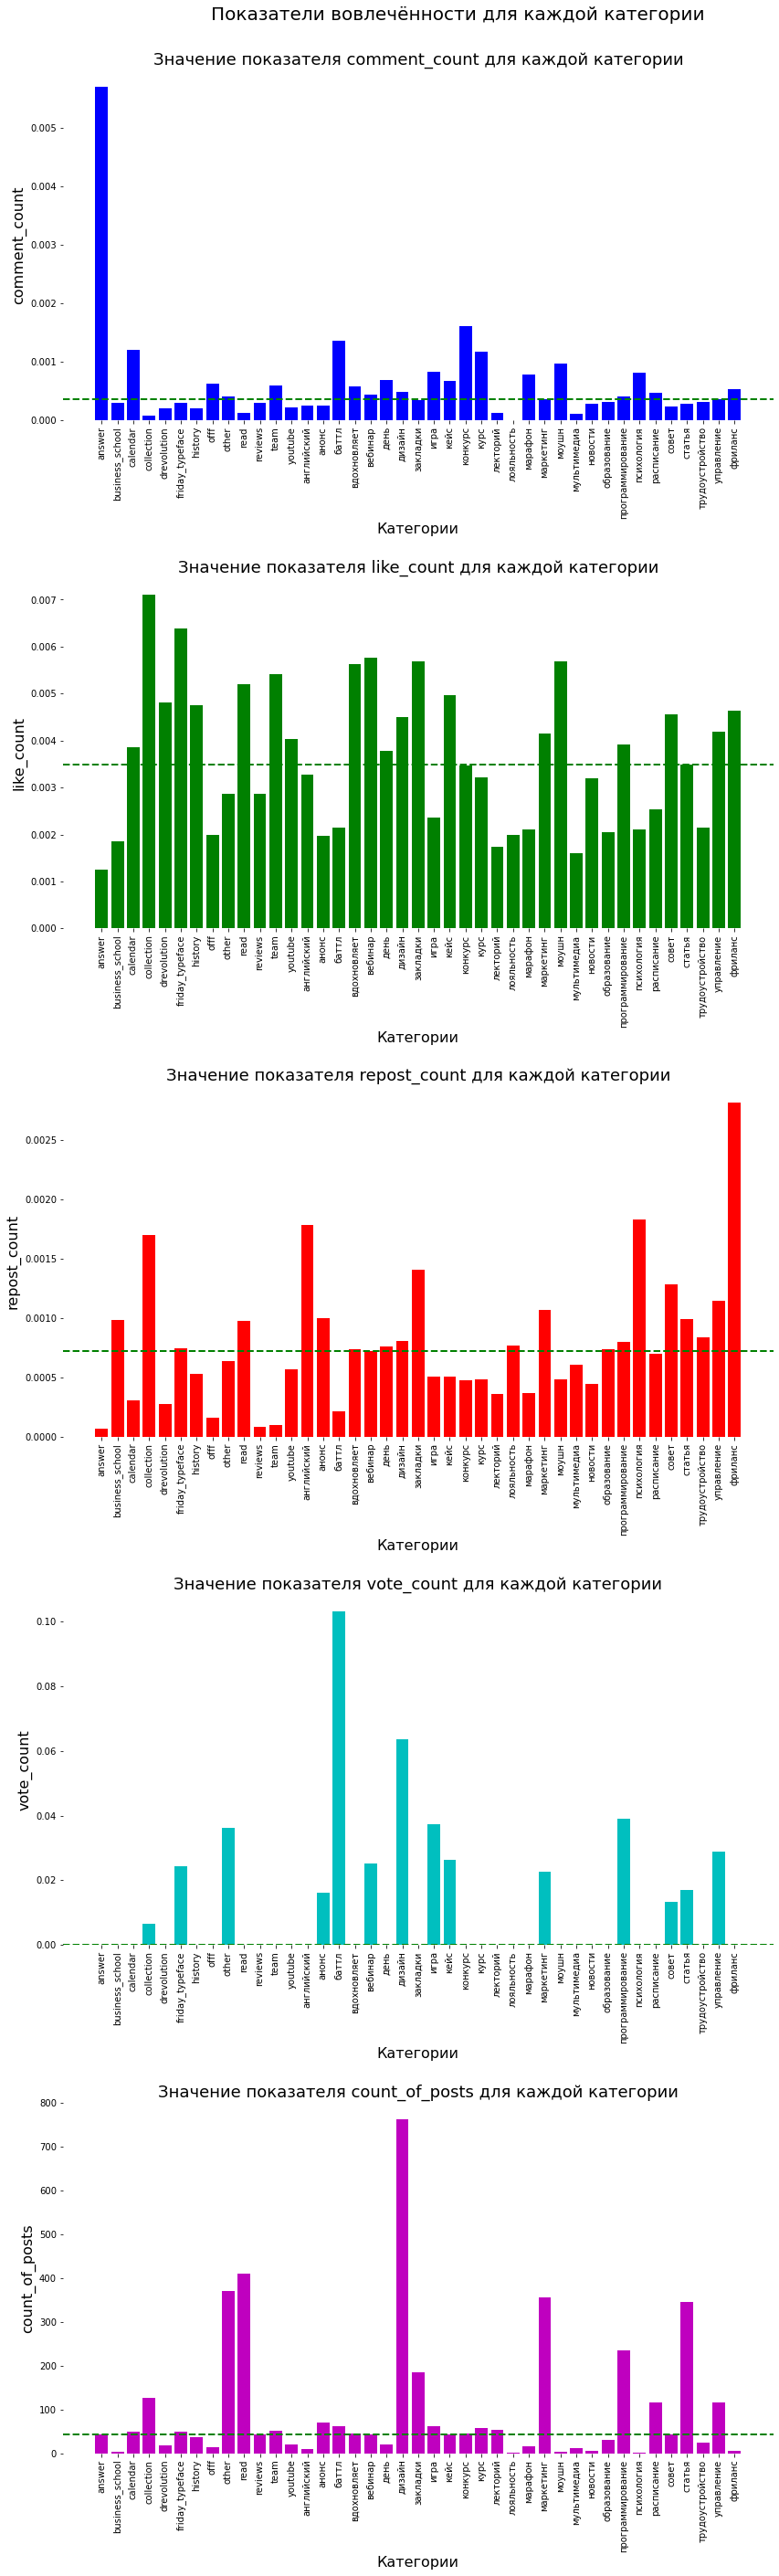

In [23]:
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

# Создадим список закодированных цветов для получения графиков разных цветов:

colors = ['b', 'g', 'r', 'c', 'm']

# Создадим список показателей:

indicator_list = ['comment_count', 'like_count', 'repost_count', 'vote_count', 'count_of_posts']

# Создадим фигуру:

fig, axs = plt.subplots(figsize=(12, 48), nrows = 5) 

# Заполним фигуры значениями из датафрейма:

for i in range(len(indicator_list)):
    
    # Создадим ссылку на элемент из списка axs:
    
    ax = axs[i]
    
    # Создадим вспомогательный датафрейм для конкретного показателя вовлечённости:
    
    if indicator_list[i] != 'count_of_posts':
    
        data = grouped_df_with_view_2_3[['category', indicator_list[i], 'view_count']] 
        
        data['indicator'] = data[indicator_list[i]]/data['view_count']
    
    else:
        
        data = grouped_df_with_view_2_3[['category', indicator_list[i]]] 
        
        data['indicator'] = data[indicator_list[i]]
    
    # Построим диаграмму, задав значения для осей x и y и указав цвет графика. Также добавим линию медианы:
    
    ax.bar(data['category'], data['indicator'], color=colors[i])
        
    ax.axhline(y=data['indicator'].median(), color='green', linewidth=2, linestyle='--')            
    
    # Установим наименование оси y:
    
    ax.set_ylabel(indicator_list[i], fontsize=16)
    
    # Установим наименование оси x:
    
    ax.set_xlabel('Категории', fontsize=16)
    
    # Установим наименование заголовка графика:

    ax.set_title('Значение показателя ' + indicator_list[i] + ' для каждой категории', fontsize=18) 
    
    # Скроем линии рамки:

    ax.spines['top'].set_visible(False)

    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_visible(False)

    ax.spines['left'].set_visible(False)
    
    # Задаим поворот значений на 90 градусов для оси x:
    
    ax.tick_params(axis='x', labelrotation=90)

# Установим наименование заголовка фигуры:
    
fig.suptitle("Показатели вовлечённости для каждой категории", y=0.90, fontsize=20) 

# Зададим отступы между графиками:

plt.subplots_adjust(wspace = 0, hspace = 0.45, left = 0)

# Покажем диаграмму:

plt.show()

# Выводы:

а. Больше всего комментариев (относительно просмотров) получили посты из категорий answer, конкурс и баттл. 

б. Больше всего лайков (относительно просмотров) получили посты из категорий collection, friday_typeface и вебинар.

в. Больше всего репостов (относительно просмотров) получили посты из категорий фриланс, психология и английский.

г. Больше всего голосов в голосованиях (относительно просмотров) получили посты из категорий баттл, дизайн и программирование.

д. Больше всего постов вышло в категориях дизайн, read и other.

# 3. Произведём аналитику по рубрикам с течением времени (по месяцам) для 10 рубрик с наибольшим количеством постов (с января 2017 по сентябрь 2021).

In [32]:
import warnings

warnings.filterwarnings('ignore')

# Скопируем датафрейм из пункта 2 (только интересующие нас 10 рубрик):

df_with_view_3 = df_with_view_2_3[(df_with_view_2_3['category'] == 'дизайн') | 
                                  (df_with_view_2_3['category'] == 'read') |
                                  (df_with_view_2_3['category'] == 'other') |                                 
                                  (df_with_view_2_3['category'] == 'маркетинг') |                                 
                                  (df_with_view_2_3['category'] == 'статья') |  
                                  (df_with_view_2_3['category'] == 'программирование') |
                                  (df_with_view_2_3['category'] == 'закладки') |
                                  (df_with_view_2_3['category'] == 'collection') |
                                  (df_with_view_2_3['category'] == 'расписание') |  
                                  (df_with_view_2_3['category'] == 'управление')].copy()

# Добавим столбцы с информацией о годе и месяце размещения поста:

df_with_view_3['year'] = df_with_view_3['date'].dt.year

df_with_view_3['month'] = df_with_view_3['date'].dt.month

# Произведём группировку датафрейма по категориям, годам и месяцам, оставим только показатели вовлечённости:

grouped_df_with_view_3 = df_with_view_3.groupby(['category', 'year', 'month'])[['comment_count', 'like_count', 
                                                                'repost_count', 'view_count',
                                                                'vote_count']].mean().reset_index()

# Заменим значения Nan для 'vote_count' на 0:

grouped_df_with_view_3['vote_count'] = grouped_df_with_view_3['vote_count'].fillna(0)

# Добавим в датафрейм новый столбец с датой замера средних показателей вовлечённости: 

grouped_df_with_view_3['control_date'] = pd.to_datetime(grouped_df_with_view_3.year.astype(str) 
                                                          + grouped_df_with_view_3.month.astype(str), format='%Y%m')

# Средние показатели вовлечённости по категориям для каждого года и месяца:

In [33]:
grouped_df_with_view_3

,category,year,month,comment_count,like_count,repost_count,view_count,vote_count,control_date
0,collection,2018,3,0.0,111.250000,23.500000,13510.500000,0.0,2018-03-01
1,collection,2018,4,4.9,88.800000,17.200000,17222.600000,0.0,2018-04-01
2,collection,2018,5,1.4,70.000000,14.400000,6653.800000,124.0,2018-05-01
3,collection,2018,6,2.0,256.250000,63.250000,44219.500000,0.0,2018-06-01
4,collection,2018,7,1.0,107.666667,25.333333,18796.111111,0.0,2018-07-01
...,...,...,...,...,...,...,...,...,...
334,управление,2021,5,20.0,135.000000,102.000000,33982.000000,0.0,2021-05-01
335,управление,2021,6,0.4,28.600000,15.000000,17281.000000,0.0,2021-06-01
336,управление,2021,7,5.0,33.800000,19.600000,31766.600000,0.0,2021-07-01
337,управление,2021,8,9.0,64.000000,39.000000,31669.000000,0.0,2021-08-01


# Построим графики зависимости показателей вовлечённости от месяца и года по категориям  (с января 2017 по сентябрь 2021):

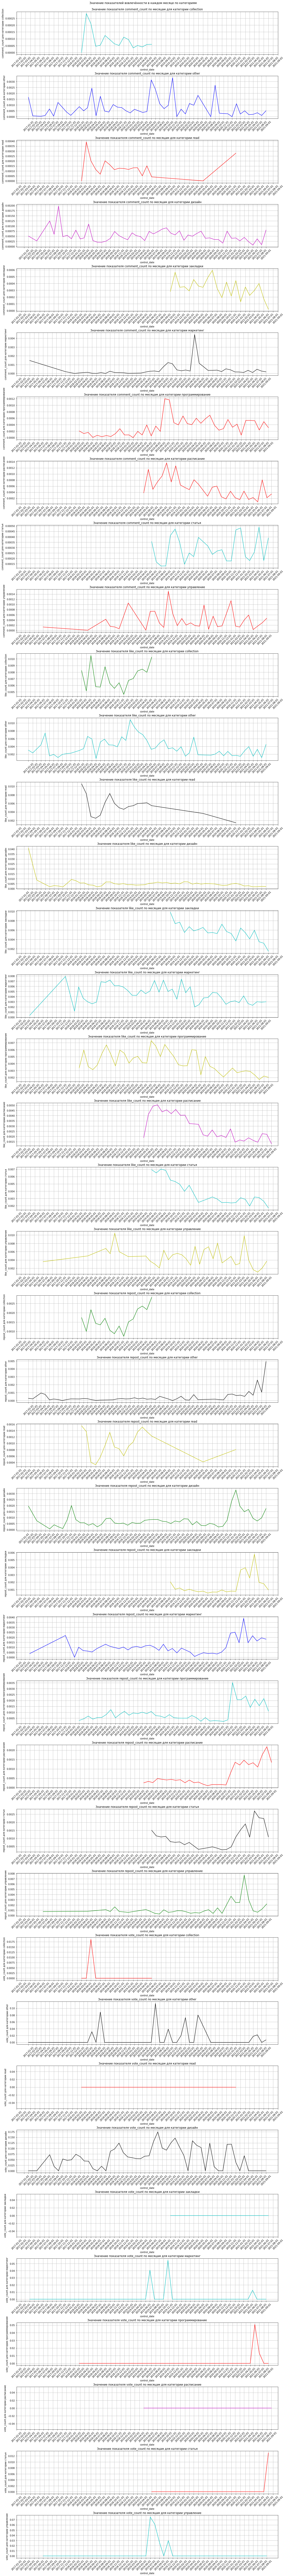

In [55]:
import matplotlib.pyplot as plt

from dateutil.relativedelta import relativedelta

import random

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Cоздадим список контрольных дат для кастомной разбивки оси x по контрольным датам:

control_date_list = []

# Создадим первую контрольную дату и добавим её в список:

first_date = pd.to_datetime('2017' + '01' + '01', format='%Y%m%d').date()

control_date_list.append(first_date)

# Создадим цикл для добавления в список первого числа каждого месяца каждого года из диапазона 
# каждый месяц в диапазоне от января 2017 до сентября 2021 включительно:

for i in range(1,57):
    
    control_date_list.append((control_date_list[i-1] + relativedelta(months=+1)))
    
# Создадим фигуру с 40 пустыми полями для графиков:

fig, axs = plt.subplots(figsize=(20, 200), nrows=40)

inclusion_indicator_list = ['comment_count', 'like_count', 'repost_count', 'vote_count']

# Заполним фигуры значениями из датафрейма:

for i in range(len(inclusion_indicator_list)):
    
    for j in range(len(grouped_df_with_view_3['category'].unique())):
    
        # Создадим вспомогательный датафрейм для конкретного показателя для конкретной категории:
    
        data = grouped_df_with_view_3[grouped_df_with_view_3['category'] 
                                      == grouped_df_with_view_3['category'].unique()[j]][['control_date', 
                                                                                          inclusion_indicator_list[i], 
                                                                                          'view_count', 
                                                                                          'category']]
    
        data['rilative_indicator'] = data[inclusion_indicator_list[i]]/data['view_count']
    
        # Создадим ссылку на элемент из списка axs:
    
        ax = axs[int(str(i) + str(j))]
    
        # Построим график, задав стобцы вспомогательного датафрейма в качестве значений для осей x и y и указав цвет графика:
    
        ax.plot(data['control_date'], data['rilative_indicator'], color=random.choice(colors))
    
        # Установим наименование оси y:
    
        ax.set_ylabel(inclusion_indicator_list[i] + ' для категории ' + grouped_df_with_view_3['category'].unique()[j])
    
        # Установим наименование оси x:
    
        ax.set_xlabel('control_date')
    
        # Установим наименование заголовка графика:

        ax.set_title('Значение показателя ' + inclusion_indicator_list[i] 
                     + ' по месяцам для категории ' + grouped_df_with_view_3['category'].unique()[j]) 
    
        # Задаим поворот значений на 45 градусов для оси x:
    
        ax.tick_params(axis='x', labelrotation=45)
    
        # Сделаем разбивку оси x по контрольным датам из списка 'control_date_list':

        ax.set_xticks(control_date_list)

        ax.set_xticklabels(control_date_list)
    
        # Добавим сетку:
    
        ax.grid()
    
# Установим наименование заголовка фигуры:
    
fig.suptitle("Значение показателей вовлечённости в каждом месяце по категориям", y=0.883)  

# Зададим отступы между графиками:

plt.subplots_adjust(wspace = 0, hspace = 0.5)
  
# Покажем графики:

plt.show()

# Выводы:
1. По количеству комментариев с апреля по август 2018 года видим максимумы для категорий collection, read и other.

2. По количеству комментариев в ноябре 2019 года видим максимумы для категорий other, закладки, маркетинг, программирование, статья, управление.

3. По количеству комментариев с апреля по май 2020 года видим максимумы для категорий other, маркетинг, статья, расписание.

4. Если смотреть количество комментариев отдельно по категориям без обобщений: 
- для категории collection максимумы в апреле 18 (самый значительный максимум, затем значительное снижение), августе 18, декабре 18;
- для категории other максимумы в апреле 18, августе 18, июне 19, ноябре 19, мае 20, сентябре 20 (в среднем наиболее продуктивным был период с мая 2019 по октябрь 2020);
- для категории read максимумы в апреле 18, августе 18 (затем постепенное снижение), с мая ноябрь 20 рост с максимумом в ноябре;
- для категории дизайн максимум в сентябре 17 (в целом для дизайна весь период выглядит достаточно равномерно);
- для категории закладки максимумы в ноябре 19 и июле 20, в среднем период с ноября 19 по июль 20 более продуктивен, чем последующий;
- для категории маркетинг с апреля 17 (сразу после первого поста) шло постепенное снижение, затем увеличение с мая 19 (с максимумом в ноябре 19), самый значительный пик в мае 20, затем возврат к средним значениям периода с мая 19 по март 20;
- для категории программирование самые значительные максимумы были в октябре-ноябре 2019 года, после этого в среднем количество комментариев держится на уровне в 2-3 раза больше, чем до максимума;
- для категории расписание наиболее значительные пики были вскоре после появления первых постов в июне 2019, октябре 2019 и декабре 2019, затем пошло волнообразное снижение, правда в июле 21 года был пик;
- для категории статья примерно одинаковые максимумы в ноябре 19, апреле 20, декабре 20, январе 21, мае 21. Значительные максимумы сменяются значительными минимумами, тенденций к росту или падению в среднем не видно.
- для категории управление наиболее значимые пики в феврале 2019, ноябре 2019, январе 2021. Значительные максимумы сменяются значительными минимумами, тенденций к росту или падению в среднем не видно. 

5. Когда смотрим ситуацию по лайкам для каждой категории, картина получается такая же, как в пункте 1 (когда не было разделения на категории): с 2019 года происходит постоянное снижение среднего количества лайков.

6. После ноября 20 года по большинству рубрик произошёл значительный рост количества репостов.

7. По количеству голосов более менее широкую картину в исследуемый период имеем только для категории дизайн. Максимумы сменяются минимумами. Максимумы примерно одинаковые.